In [4]:
#Libraries for Model Visualization
from comet_ml import Experiment

In [5]:
experiment = Experiment(api_key="MHehhbanm9HbbvXptMjQ0hinn",
    project_name="tweet-sentiment-analysis",
    workspace="jessica-njuguna")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/jessica-njuguna/tweet-sentiment-analysis/a788127290bb4d2c86fc48c1a439a043
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Error logging git-related information
COME

# Climate Change Analysis Belief 2022
© Explore Data Science Academy

_Prepared by:_
- Jessica Njuguna
- Stanley Agbo
- Uchenna Unigwe
- Hunadi Mawela
- Teddy Waweru

<a id="one"></a>
## 1. Introduction

Living things are dependent on particular conditions to survive. Humans are not exempt from this. Having the right temperature, sufficient water, clean air, and enough food are among the basic requirements for survival. The majority of these requirements depend on the stability of climate change. Climate change refers to shifts in the weather and temperature patterns. Human activity and natural occurrences contribute to climate change.

Since the 1800s, human cultures have been the main drivers of climate change. With increased deforestation, combustion of fossil fuels and increased livestock farming, the concentration of greenhouse gases has increased. These gases cause a greenhouse effect by trapping the sun's heat and escalating global warming.

Warmer temperatures change weather patterns disrupting the natural conditions of the earth. These disruptions harm our environment, degrading the quality of the Earth's air and water. In a bid to cool the earth and reduce the rate of climate change, global organizations are campaigning for more environmentally friendly products and practices. 

### Problem Statement

In the 21st Century, more companies build their brand with the consideration of **lessened environmental impact** or **carbon footprint**. Thus, their operations products and services are inclined to being more **environmentally friendly** and sustainable, in line with their values and ideals. <br>
To improve market research on their products/services, we developed the folowing **ML project** that intends to determine how people **perceive climate change**, and _whether or not they believe it is a real threat_. <br>

We believe this would provide a **metric** on how companies' products/service may be **received by the public**. Providing a robust ML solution will enable our clients to **access to a broad base of consumer sentiment**, spanning multiple demographic and geographic categories - thus **increasing their insights and informing future marketing strategies**.<br>

To build our **predictive model** for the project, we utilized a dataset of **collected tweet data** to determine if a person believes in climate data or _not_.


### Table of Contents

<a href=#one>1. Introduction </a>
- Problem Statement
- Table of Contents
- Summary
    - Agenda
    - Deliverables
    - Results
    - Future Considerations
- Preliminary Activities
    - Importing Packages
    - Loading the Datasets
    
<a href=#two>2. Exploratory Data Analysis </a>
- Statistical Summaries
    - Train Dataset
    - Test Dataset


<a href=#three>3. Data Engineering </a>
- Data Cleaning
- Text Cleaning
- Splitting features
- Text Vectorizer
- Data Balancing

<a href=#four>4. Modelling </a>
- Functions Declaration
- Bernoulli Naive Bayes Classification
    - Introduction #
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Multinomial Naive Bayes Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Logistic Regression Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Support Vector Machine Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Hyper Parameter Tuning

<a href=#five>5. Model Performance Comparison </a>


<a href=#six>6. Model Explanation </a>

<a href=#seven>7. Conclusion </a>

<a href=#eight>8. Appendix </a>
- Kaggle Submission
    - Functions Declaration
    - Submission Metrics

### Summary

**Agenda:**

The project covers the analysis and prediction of climate change sentiments. The data is from users' content on Twitter. The Machine Learning algorithm is targeted towads companies interested in taking climate action.

**Deliverables:**

The team is tasked to give insights about the Sentiment analysis. In addition, we are developing have a Machine Learning Algorithm that predicts Climate change sentiments.

**Results:**

- Majority of people in the data provided believe that Climate Change is a threat.
- The Logistic Regressor is the final model used to predict sentiments with a 73% accuracy.

**Future Considerations:**

- Employing feature selection methods.
- Scraping websites to gain more insights and improve the model.


### Preliminary Activities

#### Importing Packages

In [6]:
# Libraries for data loading, data manipulation
import pandas as pd

# Libraries for mathematical analyses
import numpy as np

#Libraries for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
from wordcloud import WordCloud
from statsmodels.graphics.correlation import plot_corr
from PIL import Image, ImageOps, ImageEnhance, PILLOW_VERSION
from wordcloud import STOPWORDS

#Libraries to clean the text
import contractions #This expands contraction such as 'don't' to 'do not'
import regex as re
import string
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import emoji #allows us to manipulate with emojis
import itertools

#Libraries for text pre-processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Libraries for data balancing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


# Libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Libraries for Model Performance
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import plot_tree

#Library for creating pickle files of the models
import pickle

# Setting global constants to ensure notebook results are reproducible
# PARAMETER_CONSTANT = ###

<ipython-input-6-b5b7c763ed81>:13: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  from PIL import Image, ImageOps, ImageEnhance, PILLOW_VERSION


#### Loading the datasets

The project has two datasets:

1. The train data
    - This is the data that will be used to teach the Machine Learning Algorithm(model) to predict the sentiments.
2. The test data
    - The observations here will be predicted to gauge the prediction accuracy of the model(s) trained.

In [7]:
#A00
#load the datasets in raw_df
raw_train_df = pd.read_csv('resources/data/train.csv')
raw_test_df = pd.read_csv('resources/data/test.csv')

<a id="two"></a>
## 2. Exploratory Data Analysis

Exploratory Data Analysis(EDA) refers to investigating the data in its raw form to spot anomalies, discover patterns and check for assumptions using summary statistics.

Preliminary checks of the EDA include:

1. Columns in the data
2. Number of observations in the data
3. Presence of missing values in the data
4. Presence of duplicates
5. Type of data in the columns; numerical(discrete, continuous), categorical or time
6. Presence of outliers/uncommon observations

The patterns existing in the dataset can be displayed using graphs and visuals. To outline the patterns, we look at:
- Patterns in the individual columns (univariate analysis)
- Patterns between columns (multivariate analysis)

Analysis of the patterns allows us to test hypotheses that can give us insight into the topic the data covers. Going through the EDA process is necessary because it highlights the steps for preparing the data for prediction modelling.

### Statistical Summaries

Statistical Summaries are used to communicate information about large datasets by summarizing the set of observations. 

For this project, we will look at measures of central tendancy (mean, mode) and distribution (skewness and kurtosis). The features of the dataset in this project is expected to be text data.

The first part of our EDA we will check if our data has anomalies, particularly the null values and the duplicates. We will step in to the tweets and explore features about the tweets. Finally, the test dataframe will be analysed as well.

#### Train Dataset

We have loaded two datasets: train and test. This section explores the train dataframe. 

First, we make a copy of the train dataset. Any manipulations on the copied data frame does not have an effect on the raw train_df. The below cell can be re-run to refresh the train_df in the event of an error.

In [8]:
#A00
#Set deep as True to copy both the indices and data of the df
train_df = raw_train_df.copy(deep = True)

Next, we view the first five columns of the dataset. This gives us an overview of the columns and a preview of the rows

In [9]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


From the first five rows we see that the train df contains _three columns_ containing the tweet in the message column, the sentiment in numerical figures and the tweetid. 

The sentiment is our target variable, which we will attempt to predict. The message column is our feature variable which will be used to describe the sentiment.

Sometimes, data is inappropriately stored and can cause issues when performing analysis. Therefore, we check the data type of the columns using .info(). If the data is inappropriately stored, we change the data type.

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


<u>Insights</u>
- The sentiment is stored as integer. 
- The tweetid column is stored as integers. 
- The message is stored as string. 

These data types match the contents in the column. 

Before feeding the data into the model, the message column will be expanded to give features with a numerical score in the feature engineering section. This will be done using vectorization. Vectorization takes the words in the columns and assigns them a numerical figure based on calculations on its frequency in the column.

Next, we inspect the number of observations in the dataframe. This allows us to see how many values we will be working with in the modelling phase.

In [11]:
train_df.shape[0]

15819

<u> Insights </u>

The dataset contains 15,819 observations.

Finally, we check if our train dataframe has missing data.

<u>Missing data</u>

- Missing data refers to empty values in the data set. They are also referred to as null values and are represented as 'NaN'. Columns with alot of missing data can be dropped. The criteria of whether to drop a column with null values can be determined by a threshhold. If the column does not surpass a stipulated null value thresh hold, the null values can be replaced with the most frequent value in the column or the average of the column. 

We check for missing data by summing the number of null values for each column below.

In [12]:
train_df.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

There are no null values in the dataset. Therefore, no imputation will be perfomed on the data set. With these checks done, we can step into the columns in the dataset.

##### Tweet ID

In [13]:
#Checking for duplicates
print('Number of unique tweet id:', len(train_df['tweetid'].unique()))

Number of unique tweet id: 15819


Each tweet id is unique. It is our identifier variable. To preserve data integrity, it is important to have this column. However, when training a Machine Learning Algorithm it is best practice to drop this variable as it is not related to the target variable. Next, we view the range of this column.

In [14]:
#Inspecting the tweetid column
#Print the minimum id number
print('Lowest tweetid:', train_df['tweetid'].min())

#print the maximum id number
print('Highest tweetid:',train_df['tweetid'].max())


Lowest tweetid: 6
Highest tweetid: 999888


- The tweetid column is in numerical figures ranging from 6 to 999888

Now that we have general information about the dataset, we look at our target variable. 


##### Sentiment

The sentiments are our target variable, using value_counts we see the different categories of sentiments and their corresponding number of observations and visualize with a bar graph

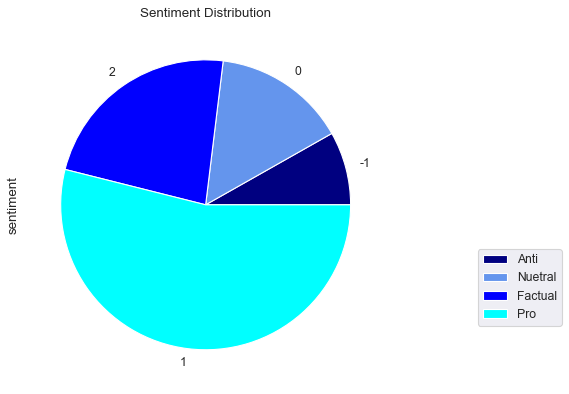

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [15]:
#set the figure size
plt.figure(figsize=(8,6), dpi=80)


#define the colors of the plot
mycolors = ["navy", "cornflowerblue", "blue", "aqua"]

#plot the frequency of the sentiments:
#using df.plot function
train_df['sentiment'].value_counts(ascending = True).plot(kind = 'pie', 
                                                          title = 'Sentiment Distribution', 
                                                          xlabel = 'Sentiments',
                                                         colors = mycolors
                                                          )
#setting the label names
plt.legend(['Anti', 'Nuetral', 'Factual', 'Pro'], 
           loc ="lower right", bbox_to_anchor =(1.5, 0.15))

#show the plot
plt.show()
#display the actual values of the sentiments
train_df['sentiment'].value_counts()

<u> Insights </u>

As seen above, the sentiment column has four unique integers. From our problem statement, we derive the following meanings for each category:
- 2 News: the tweet links to factual news about climate change
- 1 Pro: the tweet supports the belief of man-made climate change
- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1 Anti: the tweet does not believe in man-made climate change

From the cell above, we see that Pro sentiments are the highest in the dataset with 8,530 observations. The Anti The sentiments are lowest with 1,296 obseravations. 

Therefore, our data has more information about Pro sentiments than it does about Anti sentiments. This is a representation gap that is reffered to as _imbalanced dataset_. Due to the insufficient information we have about the lower frequency sentiments,  the learning capability of our model is compromised.

In the feature engineering section, we will fix this by randomly selecting examples from the minority sentiments and adding them to the dataframe with replacement.


##### Message

The message column contains values in text. They are from twitter users. This is our feature column.

We will first check for duplicates.

<u> Duplicates </u>

Incorrect duplicates affect the learning capability of the model. It is an anomally that gives conflicting information to the model. For this reason, we check for duplicates in the data. In the Feature Engineering section, we will drop the duplicate rows.


In [16]:
#Checking the number of unique values

len(train_df['message'].unique())

14229

There are 14,229 unique tweets which is less than the number of rows in the dataset. This is an indication of duplicated tweets in the dataset.

Let us plot a graph to see the number of message duplicates per sentiment.

<ipython-input-17-c36246af7096>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


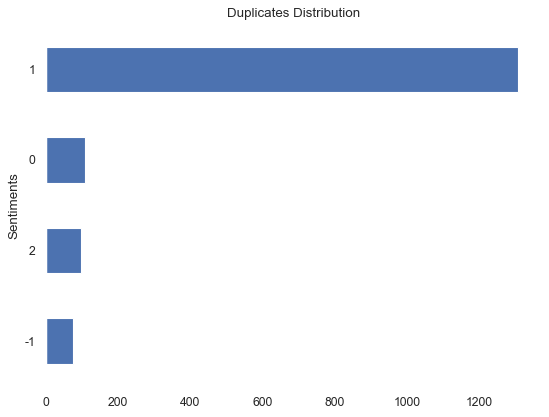

 1    1308
 0     109
 2      98
-1      75
Name: sentiment, dtype: int64


In [17]:
#create a dataframe of duplicates
dupli = train_df[train_df.duplicated(['message'])]

#set the size of the plot
plt.figure(figsize=(8,6), dpi=80)
#generate the horizontal bar graph:
#using df.plot

dupli['sentiment'].value_counts(ascending = True).plot(kind = 'barh', 
                                                       title = 'Duplicates Distribution', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency')
ax = plt.axes()
ax.set_facecolor('white')
plt.grid(False)
plt.savefig('duplicates.png')
plt.show()

#display the frequency of the duplicates per sentiment
print(dupli['sentiment'].value_counts())

The Pro sentiments have the highest number of duplicates and also the highest number of observations in the dataset.

As stated earlier, duplicates in one column have the risk of carrying conflicting data which compromises the model. We check this by grouping the tweets and counting the unique sentiments of the grouped tweet. If a tweet has more than one unique sentiment, we conclude that it is carries conflicting data.

In [18]:
#filter the tweets: 
#that have more than one sentiment and create a df

duplicates = train_df.groupby('message').filter(lambda x: len(x['sentiment'].unique()) > 1)

#display the contents in the df
duplicates

,sentiment,message,tweetid
258,-1,RT @Uniocracy: They'll tell you theyre doing i...,529327
2390,2,RT @Channel4News: .@LeoDiCaprio calls on citiz...,460524
5393,0,RT @Uniocracy: They'll tell you theyre doing i...,723133
8446,0,RT @realDonaldTrump: Where the hell is global ...,228082
9141,0,RT @COP22: In 4 days the most ambitious climat...,407156
10351,1,RT @Channel4News: .@LeoDiCaprio calls on citiz...,93815
12001,-1,RT @realDonaldTrump: Where the hell is global ...,663534
14103,1,RT @COP22: In 4 days the most ambitious climat...,357058


Out of the duplicated observations, 8 of them are not equal in sentiment. These give us confilicting information about the relationship betweeen the tweet and the sentiment. 

Considering that the train dataset is imbalanced, we will drop the duplicates in the feature engineering section.

##### Exploring the features in the tweets

<u> Popular words </u>

In this segment, we step into the tweets. We take a sample and view what it contains. One way to do this is through wordclouds.
Wordclouds are graphical representations of word frequency. It gives priority to more frequent words, and displays them with different font sizes. More frequent words appear larger than the less frequent words.

Generating the word cloud, gives us insight to what is prominent in each sentiment represented. We will also view the anomolies in the tweets that will be cleaned in the Feature Engineering section.

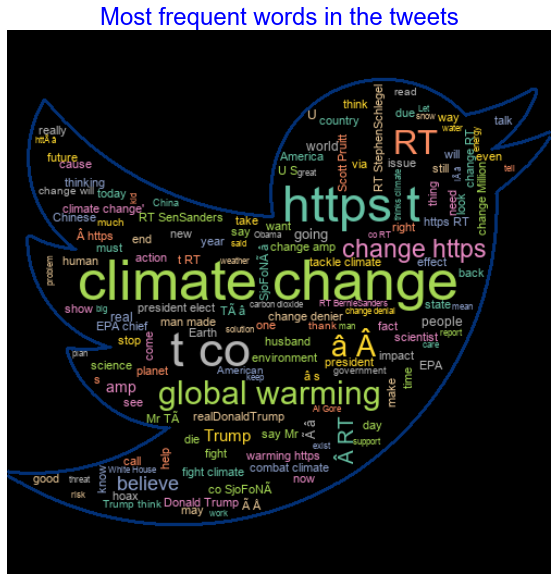

In [19]:
#generating the wordcloud to show the top 500 words
# set width and height to higher quality, 5000 x 4000

#upload an image to fit the wordcloud
mask = np.array(Image.open(
                r'C:\Users\USER\Downloads\image.png'))
#change the image color to all white
mask = mask +255

#defining the features for the wordcloud
wordcloud = WordCloud(width = 4000, height = 5000, font_path = 'arial', 
                      background_color="black", mask = mask, 
                      max_words=500, min_font_size = 8, 
                      colormap = 'Set2', contour_color='#023075',
                      contour_width=3).generate(' '.join(train_df['message']))

# set the figsize
plt.figure(figsize=[20,10])

#set the title
plt.title('Most frequent words in the tweets', fontsize = 24, color = 'blue')

# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")

# remove plot axes
plt.axis("off")
#display the wordcloud
plt.show()
#saving the wordcloud as png
#wordcloud.to_file("wordcloud_general.png")

<u> Insights </u>
- The wordcloud has generated the top 500 words in the message column. 
- Climate change and global warming are the most frequent words judging by their size. This is in line with the project topic. 
- Words that are not in English e.g.  SjoFoNá, and 
- Words that are not directly related to expressing a sentiment like 'RT'. 

The presence of characters and words that are not related to the subject is referred to jargon. It also includes common words that are used to join sentences. The process of eliminating the data in the tweets that is unnecessary to the sentiment is called garbage in, garbage out. In the feature engineering section, we will perform this task before modelling the data.


Let us step into the tweets per sentiments and generate word clouds to check for patterns in the top 500 words.

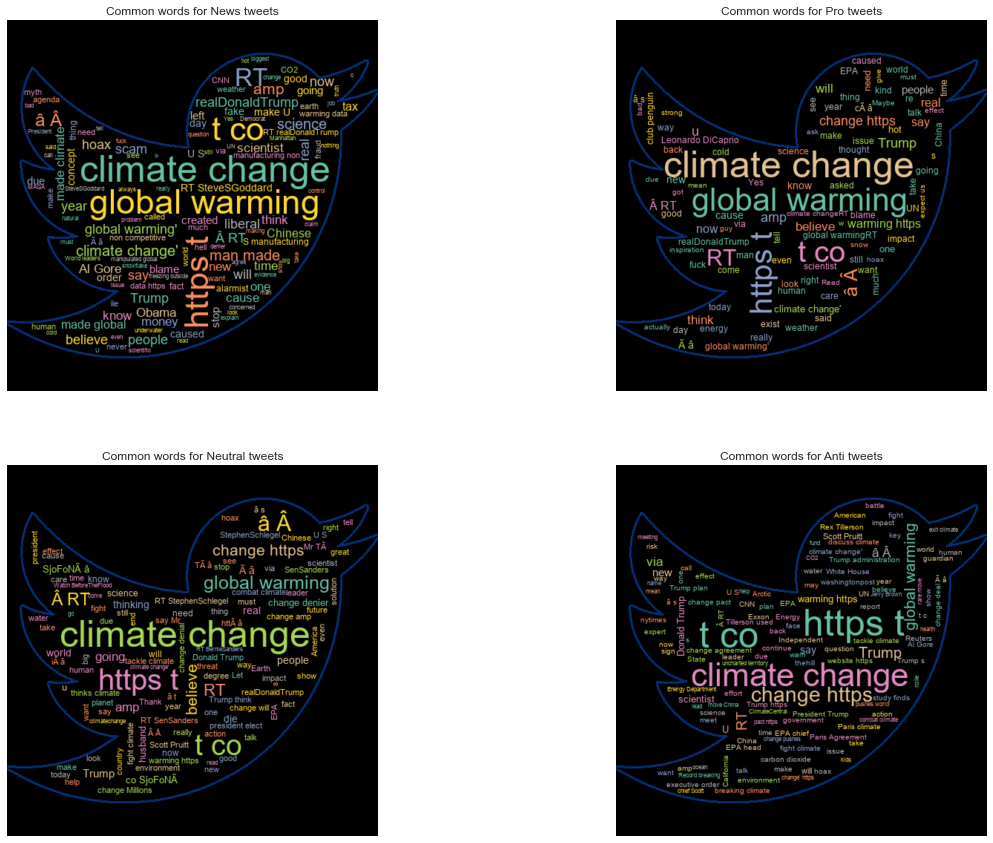

In [20]:
#group the sentiments and join the tweets for those sentiments
train_grouped=train_df[['sentiment','message']].groupby('sentiment').agg(sum)

#create a list for each of the sentiments
text_list = [train_grouped.iloc[0,0], train_grouped.iloc[1,0],
             train_grouped.iloc[2,0], train_grouped.iloc[3,0]]



#design the wordcloud
wordcloud = WordCloud(width = 4000, height = 5000, font_path = 'arial', 
                      background_color="black", colormap = 'Set2', mask = mask, contour_color='#023075',contour_width=3,
                      max_words=500, min_font_size=8, max_font_size=50)

#create a list of the titles
title = ['Common words for News tweets',
        'Common words for Pro tweets',
        'Common words for Neutral tweets',
        'Common words for Anti tweets']
#set the size of the graph
plt.figure(figsize=[20,15])
# Iterate over the grouped sentiments
for i in range(0, len(text_list)):
    
    #generate a wordcloud for each sentiment
    wordcloud.generate_from_text(text_list[i])
    
    #populate all in the same output
    plt.subplot(2, 2, i + 1)
    #show the wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    #remove the axis
    plt.axis("off")
    #set the title from the title list
    plt.title(title[i])

    
plt.show()

The wordcloud shows that:
- Climate change and global warming are the most frequent words for each of the wordclouds, similar to the general tweets wordcloud
- There is unnecessary jargon and common words that make it hard for us to derive insights

As stated earlier, we will clean the data in the Feature Engineering section and generate more insights.


**Tweet Features**

To explore the tweets in the dataset, we look at the features that summarizes information about the tweet.

The new features will be numerical in nature and non-redundant. These are:

1. Tweet Length
2. Distibution of words in the tweet
3. Distibution of stop words per tweet
4. Distibution of punctuations per tweet
5. Hashtags
    - Distribution of hashtags
    - Popular hashtags
6. Distibution of mentions
7. Distibution of beginning with an uppercase letter per tweet

Let us dive in.

<u> _1. Tweet Length_ </u>

This is also referred to as the number of characters in the string. Twitter allows a maximum of 140 characters per tweet.

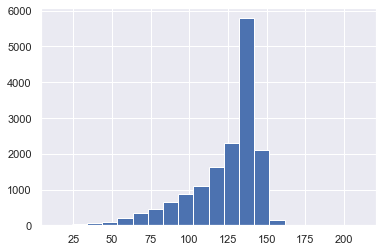

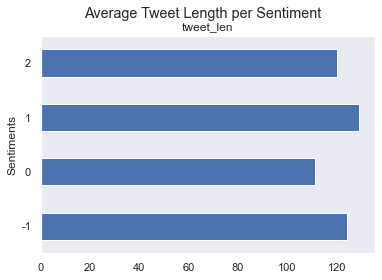

In [21]:
#get the length of the tweet
train_df['tweet_len'] = train_df['message'].astype(str).apply(len)

#plot the distribution
plt.hist(train_df['tweet_len'], bins=20,label="Train tweets")
plt.show()

#plot the average tweet length per sentiment
train_df.groupby('sentiment')['tweet_len'].mean().plot(kind = 'barh', subplots = True,
                                                       title = 'Average Tweet Length per Sentiment', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency')
plt.grid(False)
plt.show()

- The tweet length ranges between approximately 112.5 - 128.0.
- Majority of the tweets have a length of approximately 130.
- The average tweet length is 122.5. This is highly influenced by the pro sentiments which has the highest frequency in the dataset.
- The pro sentiments have the highest average tweet length with over 120.

<u>_2. Distribution of words per tweet_</u>

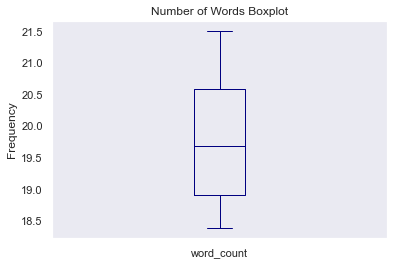

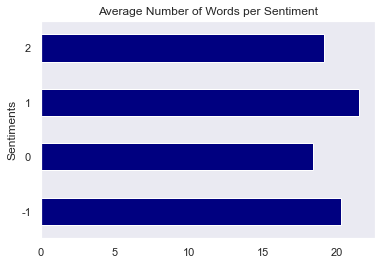

In [22]:
#count the words
train_df['word_count'] = train_df["message"].apply(lambda x: len(re.findall(r'\w+', x)))

#plot the boxplot 
train_df.groupby('sentiment')['word_count'].mean().plot(kind = 'box', 
                                                       title = 'Number of Words Boxplot', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency',
                                                       color = 'navy')
#remove the grid
plt.grid(False)
plt.show()
#plot the horizontal bar graph for the average per sentiment
train_df.groupby('sentiment')['word_count'].mean().plot(kind = 'barh', 
                                                       title = 'Average Number of Words per Sentiment', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency',
                                                       color = 'navy')
#remove the grid
plt.grid(False)
plt.show()

- The number of words range from 18 - 21, with a mean of 19.
- The neutral sentiment tweets have the lowest average number of words per tweet.
- Pro sentiments and Anti sentiments are nearly at par in the average number of words per tweet. This might be related to the high emotional connect that is linked to these beliefs.

<u>_3. Distribution of stop words per tweet_</u>

The term _stopwords_ in Data Science refers to the common words used to fill or link a sentence. These are words such as _don't_, _it_, and _this_. They occur frequently in the natural language. The identification and removal of stop words from texts increases the training quality of the model as it only highlights the keywords.

Using a natural languange processor, we have a list of these words in english that we can use in processing our data.

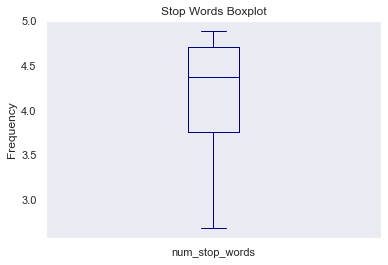

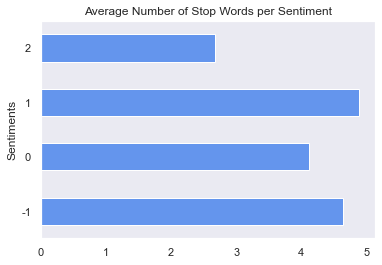

In [23]:
#define the stopwords from the ntlk stopwords list
stop_words = set(stopwords.words('english'))

#count the number of stopwords
train_df['num_stop_words'] = train_df['message'].str.split().apply(lambda x: len(set(x) & stop_words))

#plot the boxplot of stopwords
train_df.groupby('sentiment')['num_stop_words'].mean().plot(kind = 'box', 
                                                       title = 'Stop Words Boxplot', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency',
                                                           color = 'navy')
plt.grid(False)
plt.show()

#plot the bar graph of average stopwords per sentiment
train_df.groupby('sentiment')['num_stop_words'].mean().plot(kind = 'barh', 
                                                       title = 'Average Number of Stop Words per Sentiment', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency',
                                                           color = 'cornflowerblue')
plt.grid(False)
plt.show()

- Despite being the second most observed sentiment, the factual sentiments have the lowest number of stopwords.
- The Pro sentiments have the highest average number of stopwords, followed by the Anti sentiments

<u>_4. Distribution of punctuations per tweet_</u>

Similar to stopwords, punctuations occur frequently in text data. While they are useful in written text, models may mistakenly identify the punctuations as key to the sentiment. Therefore, it is key to identify their distribution for removal.

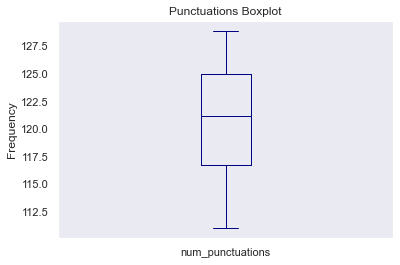

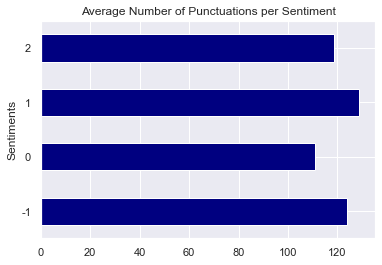

In [24]:
#count the punctuations

train_df['num_punctuations'] = train_df["message"].apply(lambda x: len(re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', 
                        x)))
#plot the boxplot
train_df.groupby('sentiment')['num_punctuations'].mean().plot(kind = 'box', 
                                                       title = 'Punctuations Boxplot', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency', color = 'navy')
plt.grid(False)
plt.show()

#plot the bar graph of average no. of punctuations per tweet
train_df.groupby('sentiment')['num_punctuations'].mean().plot(kind = 'barh', 
                                                       title = 'Average Number of Punctuations per Sentiment', 
                                                       xlabel = 'Sentiments',
                                                         ylabel = 'Frequency', color = 'navy')
plt.show()

- The maximum number of punctuations in a tweet, over 127, exceed the maximum number of words in the dataset.
- The neutral sentiment has the lowest number of punctuations as opposed to the Pro sentiments that have the highest.

<u>_5. Hashtags_</u>

Hashtags on twitter often acts as a guide to the topic of the tweet.

An example: 

    "Speaking as an @IPCC_CH Lead Author, these are some of the most important new messages from the #climate report out today: (🧵) 1. For the first time we’re seeing evidence of real, sustained decreases in greenhouse gas emissions from some countries."

The tweet above is about climate change. However, you only have to spot the hashtag _#climate_ to identify the topic of the tweet. Similarly, we can identify the hashtags in the dataset to relate to the topic.

_a. Distribution of Hashtags_

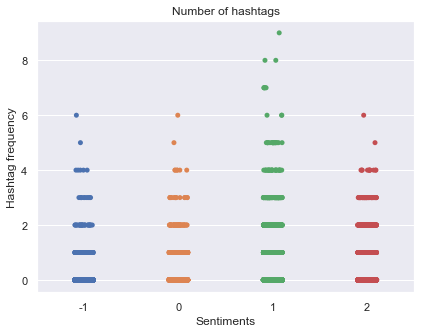

In [25]:
#count the number of hashtags in a row
train_df['num_hashtags'] = train_df["message"].apply(lambda x: len(re.findall(r'#(\w+)', x)))

#combine the strip plots of the sentiments
plt.subplot(1,3,3)
#plot the strip plot
sns.stripplot(y='num_hashtags', x='sentiment', data=train_df, jitter=True)
#set the title
plt.title('Number of hashtags')
#set the y label
plt.ylabel('Hashtag frequency')
#set the x label
plt.xlabel('Sentiments')
fig = plt.gcf()
#set the size
fig.set_size_inches( 23, 5)

plt.show()

- The number of hashtags in the tweets range from 0 - 8
- The Pro sentiments have the highest count of hashtags, 8. While the rest of the sentiments have their maximum hashtag count at 8.

_b. Popular Hashtags_


As stated above, hashtags allow us to identify the topic in the tweet. The cell below displays the top 5 hashtags per sentiment

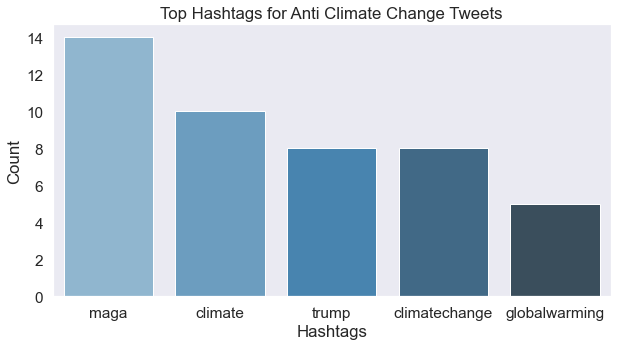

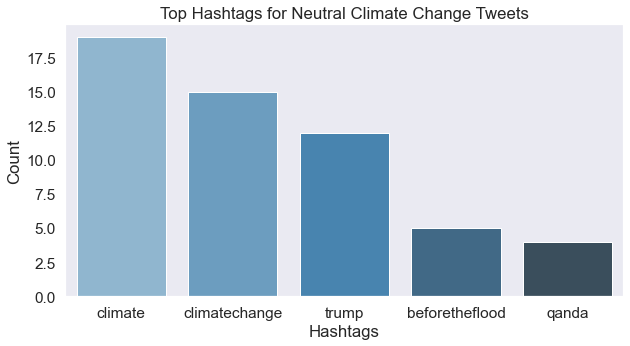

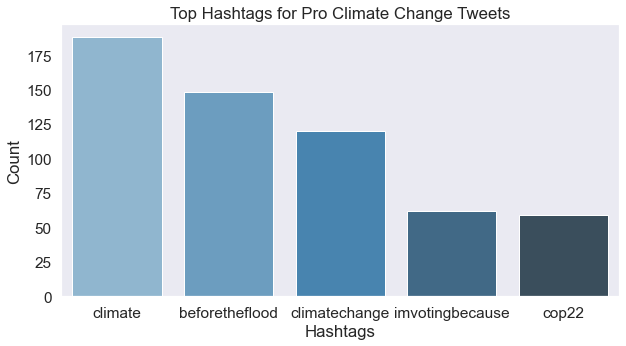

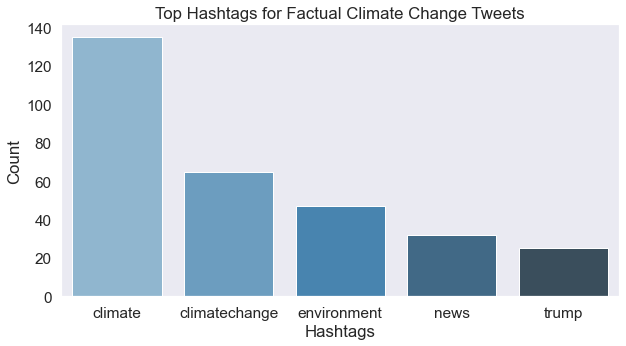

In [26]:
#define a function to extract hashtags
def get_hashtag(x):
    #create an empty list
    hashtags=[]
    for i in x: #loop over words contain in tweet
        ht = re.findall(r"#(\w+)",i)#find all the words beginning with '#'
        hashtags.append(ht)#append it to the list
    #return the list    
    return hashtags

#copy the train df
lower_train_df = train_df.copy(deep = True)
#lower all the text
lower_train_df['message'] = lower_train_df['message'].apply(lambda x:x.lower())

#get hashtags from anti sentiments
hash_anti = get_hashtag(lower_train_df['message'][lower_train_df['sentiment']==-1])
#get hashtags from neutral sentiments
hash_neutral=get_hashtag(lower_train_df['message'][lower_train_df['sentiment']==0])
#get hashtags from pro sentiments
hash_pro=get_hashtag(lower_train_df['message'][lower_train_df['sentiment']==1])
#get hashtags from factual sentiments
hash_factual=get_hashtag(lower_train_df['message'][lower_train_df['sentiment']==2])

#sum the length of 
hash_anti = sum(hash_anti,[])
hash_neutral = sum(hash_neutral,[])
hash_pro = sum(hash_pro,[])
hash_factual = sum(hash_factual,[])

#create a frequency distribution for each list
hash_anti_tweet = nltk.FreqDist(hash_anti)
hash_neutral_tweet = nltk.FreqDist(hash_neutral)
hash_pro_tweet = nltk.FreqDist(hash_pro)
hash_factual_tweet = nltk.FreqDist(hash_factual)

#create dataframes from the array 
#of the frequency distribution
df_anti = pd.DataFrame({'hash': list(hash_anti_tweet.keys()),'Count':list(hash_anti_tweet.values())})
df_neutral = pd.DataFrame({'hash': list(hash_neutral_tweet.keys()),'Count':list(hash_neutral_tweet.values())})
df_pro = pd.DataFrame({'hash': list(hash_pro_tweet.keys()),'Count':list(hash_pro_tweet.values())})
df_factual = pd.DataFrame({'hash': list(hash_factual_tweet.keys()),'Count':list(hash_factual_tweet.values())})

#create a list of the df
df_list = [df_anti, df_neutral, df_pro, df_factual]

#create a list of the titles
title = ['Top Hashtags for Anti Climate Change Tweets',
        'Top Hashtags for Neutral Climate Change Tweets',
        'Top Hashtags for Pro Climate Change Tweets',
        'Top Hashtags for Factual Climate Change Tweets']

#plotting top 5 most popular hashtags
for i in range(0, len(df_list)):
    df_list[i] = df_list[i].nlargest(columns="Count",n=5)
    plt.figure(figsize=(10,5))
    sns.set(font_scale = 1.4)
    ax = sns.barplot(data=df_list[i], x="hash", y="Count", palette="Blues_d")
    plt.title(title[i])
    
    #plt.subplot(2, 2, i + 1)
    
    ax.set(ylabel = "Count")
    ax.set(xlabel = "Hashtags")
    plt.grid(False)
    plt.show()


<u> Insights </u>

- All the sentiments have climate and climate change among the top five hashtags.


    ~ This makes it easier to identify which tweets to get from twitter.
    
- Among the top 5 hashtags for each sentiment, their is at least one connected to politics. In the factual, neutral and anti sentiments we see the name of the former president of U.S.A. Donald Trump. While the pro sentiment has #iamvotingbecause.


    ~ Climate change is a current crisis that is attracting attention from governmental institutions.

<u>_6. Distribution of mentions_</u>

Mentions are a way to refer to another twitter user. For climate change tweets, they may refer to users that lead climate change conversations. 

We look at how many mentions are in the tweets, per sentiment in the cell below.

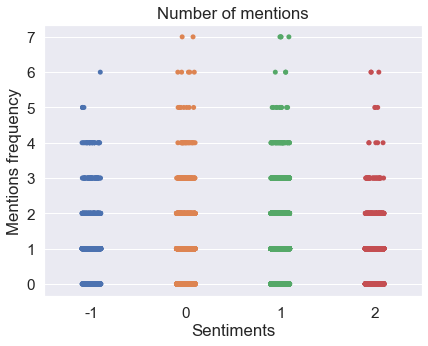

In [27]:
train_df['num_mentions'] = train_df["message"].apply(lambda x: len(re.findall(r'@(\w+)', x)))

plt.subplot(1,3,3)
sns.stripplot(y='num_mentions', x='sentiment', data=train_df, jitter=True)
plt.title('Number of mentions')
plt.ylabel('Mentions frequency')
plt.xlabel('Sentiments')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.show()

- Majority of the tweets in the data mention another user at a range of 0 - 3.
- The neutral and pro sentiments have two tweets with the highest count of mentions amongst their tweets. 

<u>_7. Distribution of words in UpperCase_</u>

Another way to identify the topics of a tweet is through the words in upper case. Except in the event of a typo, beginning of a sentence and the pronoun 'I', words that begin with an uppercase refer to an entity or a person. An entity can be a company or a place.

Let us look at the distribution of the number of entities in the tweets.

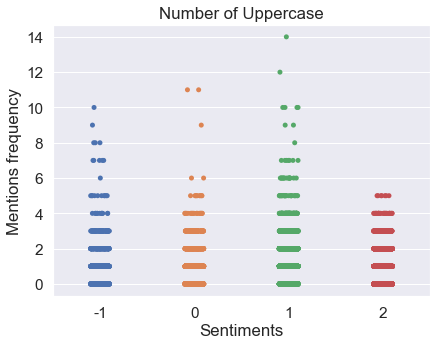

In [28]:
train_df['num_uppercase'] = train_df["message"].apply(lambda x:sum(map(str.isupper,x.split())))

plt.subplot(1,3,3)
sns.stripplot(y='num_uppercase', x='sentiment', data=train_df, jitter=True)
plt.title('Number of Uppercase')
plt.ylabel('Mentions frequency')
plt.xlabel('Sentiments')
fig = plt.gcf()
fig.set_size_inches( 23, 5)

plt.show()

The Factual sentiments, the Pro sentiments has the tweets with the highest number of UpperCase words.

##### In summary:

- Our train dataset contains 15,189 observations and three columns; tweet id, message and sentiment
- There are no missing values in the dataset
- There are duplicates that will be dropped in the Feature Engineering section
- The tweets contains jargon and words that are not necessary for gaining insights. Therefore, it will be cleaned.
- Marjority of the numerical features in the dataset score highest for the Pro sentiments. The Pro sentiments also contain the highest number of observations. The data set contains alot of unique information about the Pro sentiments.

Having extensively explored the train data set, let us proceed to do the same with the test data set.

#### Test Dataset

It is best practice to separate the data into train and test dataframe. The train dataframe will be used to teach our model while the test dataframe checks if the model predicts accurately. For this project the predictions made on the test dataframe will be submitted on the kaggle challenge.

Similar to the train dataset, we first create a copy of the dataset in accordance with best practices

In [29]:
#A00
test_df = raw_test_df.copy(deep = True)

We then proceed to view the first five rows in the dataset

In [30]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


The test dataframe has two columns with the message and tweetid. The target variable, sentiment is not present in the dataset.

The message column contains text while the tweet id contains numerical figures.

In [31]:
test_df.shape

(10546, 2)

The dataframe has 10,546 observations which we will use to predict for the model.

In [32]:
test_df.isna().sum()

message    0
tweetid    0
dtype: int64

There are no null values in the dataframe. Therefore, there is no need to drop any rows.

##### Checking for duplicates

In [33]:
len(raw_test_df['tweetid'].unique())

10546

The tweet id  has no duplicates and uniquely identifies each tweet in the dataframe. Next we check if each tweet is unique.

In [34]:
len(test_df['message'].unique())

9575

The message column has duplicates since the number of unique tweets is less than the total number of observations in the dataframe.

The code below allows us to get the exact number of duplicates using '.duplicated'.

In [35]:
test_df[test_df.duplicated(['message'])].shape

(971, 2)

In the test dataframe, we have 971 duplicate tweets. During the model prediction, we will test out if the model predicts the same sentiment for the duplicated tweets. This will help us view the accuracy of the model

##### Tweet Visualisation

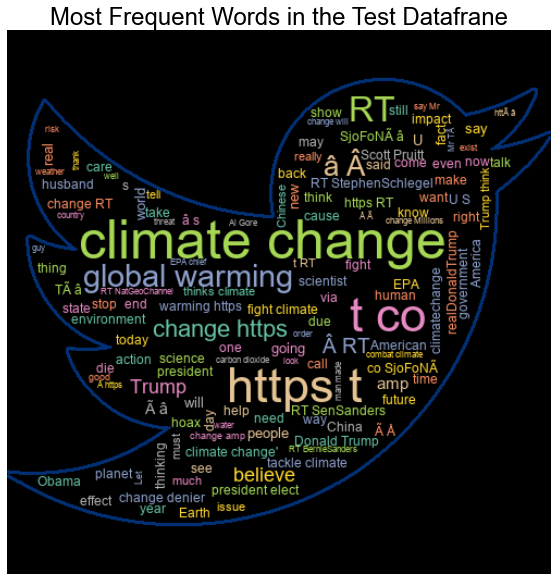

In [36]:
mask = np.array(Image.open(
                r'C:\Users\USER\Downloads\image.png'))
mask = mask +255                          
wordcloud = WordCloud(width = 4000, height = 5000, font_path = 'arial', 
                      background_color="black", mask = mask, 
                      max_words=500, colormap = "Set2",
                      min_font_size=8, max_font_size=50, 
                      contour_color='#023075',
                      contour_width=3).generate(' '.join(test_df['message']))

# set the figsize
plt.figure(figsize=[20,10])
plt.title('Most Frequent Words in the Test Datafrane', fontsize = 24, color = 'black')
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")

# remove plot axes
plt.axis("off")

plt.show()

From the wordcloud, we derive the following insights:

- Climate change, global warming are some of the most frequent words in line with our topic. 
- Presence of https shows that there are many urls
- There is jargon in the tweet, e.g. SjoFoNá
- There is a mix of pro and anti words in the columns, e.g. believe and hoax.

The noise in the data, will be cleaned through the same steps that will be done for the train dataframe. In addition, the features engineered will be applied to the test dataframe before feeding it into the model for predictions.

Now we can move on to the next section, Feature Engineering.

<a id="three"></a>
## 3. Feature Engineering


Feature Engineering refers to the process of preparing raw data for modelling. This step improves the quality of results of the model, as compared to training the model with raw data. It involves:

1. Data Cleaning:
    - This is where the cleaning up null values, duplicates and outliers is done. 


2. Text Cleaning    
    - With text data, it consists of cleaning the noise in the text data.


3. Splitting the Data
    - The features and labels will be separated at this stage to reduce the computational power required to vectorize and balance the dataset. In addition, we will split the data to train and test sets, to train and tune our models.


4. Vectorize data:
    - The additional features are derived from the existing features.


5. Data Balancing
    - This process involves reducing the volume of our data only keeping the features that are most relevant to the dataset.


For our project we will perform all the steps highlighed above on the train_df. At the end of the section, we will have a training and testing dataset from the train_df, that we will use to build a model that predicts the sentiments.

### Data Cleaning

As mentioned above data cleaning is the process of correcting the anomalies in the data. For this project, the anomalies detected in the train dataset were duplicates in the message column.

#### Dropping Duplicates

In the EDA section, we noted that there were 1,590 duplicates. Retaining duplicates presents the risk of overfitting the Machine Learning model and giving conflicting data to the model.

Overfitting refers to perfectly aligning the model to the training data. An overfitted model performs poorly on real world data, which is unseen.

First, we recap on the number of duplicates per sentiment.

In [37]:
dupli['sentiment'].value_counts()

 1    1308
 0     109
 2      98
-1      75
Name: sentiment, dtype: int64

The Pro sentiments have the highest number of duplicates and the highest number of observations. Dropping all the duplicates, will reduce the imbalance in our dataset

In [38]:
#A00
train_df = train_df.drop_duplicates('message', keep = 'first')
clean_duplicated_values = train_df[train_df.duplicated(['message'])]
clean_duplicated_values['sentiment'].value_counts()

Series([], Name: sentiment, dtype: int64)

The resulting pandas series is empty, therefore the agenda has been achieved.


Since our data contains no missing data, we can proceed to clean the text data

### Text Cleaning

Unstructured data is not organized in any pre-defined model. Eighty to ninety percent of the world's dat falls into this category. In it's raw form, it contains a mix of information that is both useful or irrelevant depending on its topic. The irrelevant information is referred to as noise. The process of removing noise form data is called garbage in and garbage out. 

For this sentiment classification model, we are interested in the text data that relates to climate change. The noise is in form of punctuations, emojis, stopwords, etc. 

To improve the quality of the data, we will clean the text by performing the following steps:

1. Expand contractions
    - Expands shortened words like don't to do not.
    

2. Replace urls
    - After removing the punctuation and digits from a link, it becomes one text that decreases the ability to identify topics in the text. Hence we will replace the url's with 'url-web'.


3. Remove digits and words containing digits
    - For the topic at hand, we are seeking text data.


4. Lower the message
    - The model reads upper case, lower case and title case words are unique words even if they are the same word. We lower the message to reduce the features in the vectorizer.
    

5. Remove punctuation
    - As mentioned in the Exploratory Data Analysis, punctuation is occurs frequently in text data and contributes to the noise. Therefore, we will remove the punctuations from the dataset.
    

6. Remove emojis
    - Emojis are graphical features that are used to express emotions. While they are not frequently observed in most data, they do not provide crutial information to the data.
    

7. Lemmetazition
    - This is the process of reducing a word to its root. It reduces plurals to singular form, adjectives to noun, etc. FOr example: jugs -> jug, chasing -> chase, sadness -> sad. etc.
    
    


The stopwords are removed by the vectorizer. We will create functions to do the preprocessing below, test the function then apply it to our train dataframe.

#### Functions Declaration

In [39]:
#A00
'''The following functions will be used to
    preprocess the train data'''

   
def preprocess(tweet):
    
    #remove urls
    tweet = re.sub(
        r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+',
        '', tweet)
          
    #remove mentions
    tweet = re.sub("@[\w]*",'', tweet)
    
    #make text lowercase
    tweet = tweet.lower() # lower case
    
    #expand contractions
    tweet = contractions.fix(tweet)
       
    #remove emojis
    tweet = emoji.replace_emoji(tweet, replace = '')
    
    #remove short words
    tweet = ' '.join([w for w in tweet.split() if len(w)>3])
    
    #remove stopwords
    tweet = ' '.join([w for w in tweet.split() if w not in stopwords.words('english')])
    
    #remove punctuation
    #tweet = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', tweet)
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet) # strip punctuation
    
         
    #lemmatize the text
    token_words = TreebankWordTokenizer().tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    lem_sentence=[]
    for word in token_words:
        #just lemmmatize
        lem_word = lemmatizer.lemmatize(word)
        lem_sentence.append(lem_word)
        lem_sentence.append(" ")
    tweet = "".join(lem_sentence)
    
    #remove digits and words with digits
    tweet = re.sub('\w*\d\w*','', tweet)
    
    #remove unwanted words
    unwanted_words = ['http', 'https', 'rt']
    tweet = ' '.join([w for w in tweet.split() if w not in unwanted_words])
    
    #remove short words
    tweet = ' '.join([w for w in tweet.split() if len(w)>3])
    return tweet



_Testing out the pre-processor_

In [40]:
tweet = 'A high of 109°F in #McAllen, #Texas?!  In early #April no less. The right tail of the extreme temperature curve continues to advance in many locations. #ClimateChange'
#tweet = re.sub('s+', ' ', tweet)
print('Processed text:', preprocess(tweet))

Processed text: high mcallen texas early april right tail extreme temperature curve continues advance many location climatechange


The pre-processor has successfully performed the following steps:
- Remove digits and words with digits (g9)
- Remove emojis (😃😃😄)
- Remove punctuation (?>)
- Replaced links (https://scikit-learn.org/)
- Lowered text (Never -> never)
- Expanded contractions (I'm -> i am)
- Lemmatized the text (nuts - nut)

_**We can now apply it to the message column to clean the tweets**_

In [41]:
#A00
train_df['message'] = train_df['message'].apply(lambda x: preprocess(x))

This is has been completed. Now let us generate the word clouds again to gain better insights.

We move on to splitting the data in preparation for vectorization.

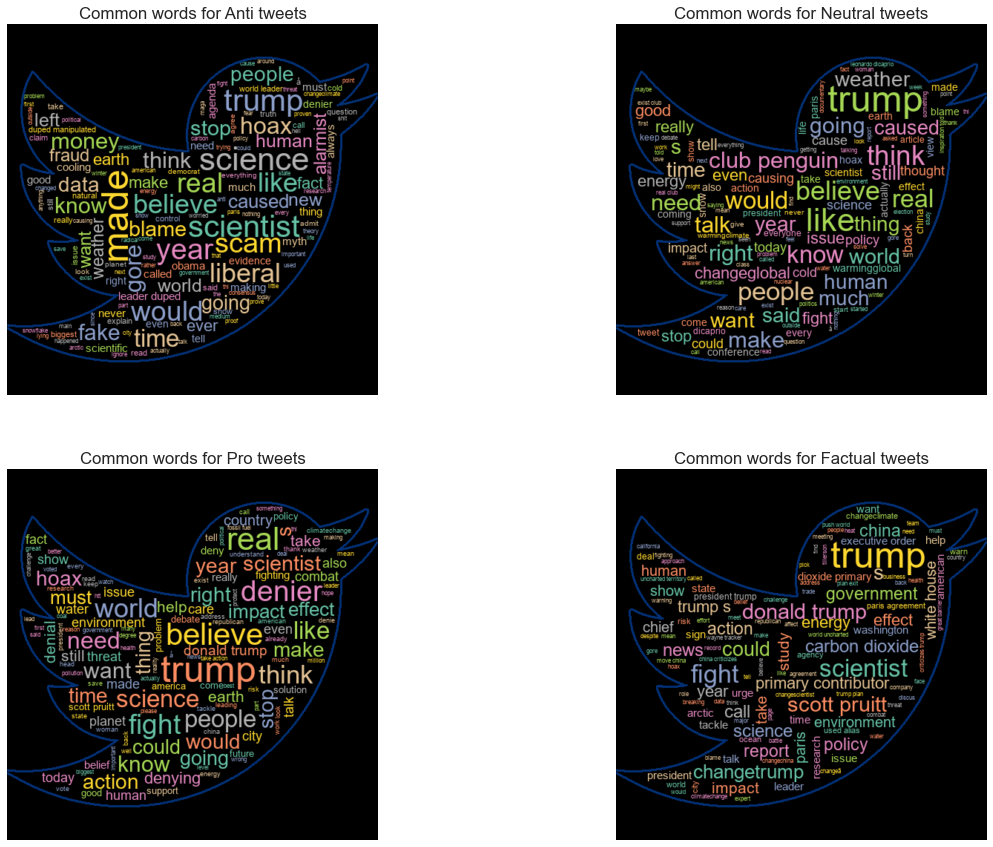

In [42]:
train_grouped2 = train_df[['sentiment','message']].groupby('sentiment').agg(sum)

text_list = [train_grouped2.iloc[0,0], train_grouped2.iloc[1,0],
             train_grouped2.iloc[2,0], train_grouped2.iloc[3,0]]

# set width and height to higher quality, 5000 x 4000
stop_words = ['climate', 'change', 'global', 'warming', 'â', 'ã', 'http', 'https', 'rt']                         
wordcloud = WordCloud(width = 4000, height = 5000, font_path = 'arial', 
                      background_color="black", colormap = 'Set2', mask = mask, contour_color='#023075',contour_width=3,
                      max_words=500, min_font_size=8, max_font_size=50, stopwords = stop_words)
title = ['Common words for Anti tweets',
        'Common words for Neutral tweets',
        'Common words for Pro tweets',
        'Common words for Factual tweets']

plt.figure(figsize=[20,15])
# Create subplots 
for i in range(0, len(text_list)):
    wordcloud.generate_from_text(text_list[i])
    plt.subplot(2, 2, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title[i])
    #wordcloud.to_file("wordcloud_general.png")

plt.show()

### Splitting the Data


The data will first split into features and labels. The features will be used to model the label variable.


In [43]:
#A00
X = train_df.drop(columns = ['tweetid', 'sentiment'], axis = 1)
y = train_df['sentiment']
X.reset_index(drop = True, inplace = True)
X.head()

,message,tweet_len,word_count,num_stop_words,num_punctuations,num_hashtags,num_mentions,num_uppercase
0,polyscimajor chief think carbon dioxide main g...,140,23,3,137,0,1,1
1,like lack evidence anthropogenic global warming,62,11,3,63,0,0,0
2,researcher three year climate change late,140,26,6,137,0,1,1
3,todayinmaker wired pivotal year climate change,99,17,5,98,1,0,1
4,racist sexist climate change denying bigot lea...,122,19,5,123,1,1,1


The dataset has been separated successfully. The feature dataframe X, does not contain the label variable, 'sentiment'. We now split the X and y variables further.

#### Splitting the Train and Test Datasets

The feature and label dataframes are split into train and test data pairs before modelling. The train pair, 70% of our data, is used by the model to learn to predict the target variable. The test pair, unseen data, is used to evaluate how well the model can predict the target variable.

In [44]:
#A00
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size=0.3)

### Text Vectorization


Text Vectorization is the process of turning text data to numerical data. The numerical figures are populated using the frequency of the text in the dataframe.

For this classification problem, we will use the TFIDF vectorizer.

#### TFIDF Vectorizer

In full TFIDF stands for Term Frequency Inverse Document Frequency. It measures how relevant a word is to the dataframe using two metrics:

1. Term Frequency
- Number of times a word appears in a row
2. Inverse Document Frequency
- How common a word is in the entire column. The closer this metric is to zero, the more common a word is.

#####                                              TFIDF = Term Frequency x Inverse Document Frequency

The higher the TFIDF score, the higher the relevance of the word to the dataset. It is because the TFIDF vectorizer scores relevance that we used it to generate features for this dataset.

The tfidf vectorizer will be applied to the message column. The features generated will be fed into the model.

In [45]:
#A00
#Function to vectorize the message column
tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df=2, strip_accents = 'ascii', 
                                   smooth_idf=False, stop_words='english')

##### TFIDF Vectorizer

In [46]:
#A00
#fit the vectorizer with the message
tfidf_vectorizer.fit(X_train['message'])

#transform the X_train data
tfidf_train = tfidf_vectorizer.transform(X_train['message'])

#transform X_test data
tfidf_test = tfidf_vectorizer.transform(X_test['message'])

#get the number of features generated
print(tfidf_vectorizer.get_feature_names_out().shape)
print(tfidf_vectorizer.get_feature_names_out()[40:45])
print(tfidf_train[0])

(4826,)
['accelerating' 'accept' 'accepted' 'accepting' 'accepts']
  (0, 4615)	0.41679955283325454
  (0, 3797)	0.39342247381521867
  (0, 2819)	0.3401928253291903
  (0, 1683)	0.3114256029756965
  (0, 1340)	0.41679955283325454
  (0, 980)	0.3401928253291903
  (0, 755)	0.056274750839761994
  (0, 673)	0.05691513347412526
  (0, 366)	0.40363426466662494


The vectorizer has created 4,986 features about the message. The features are words that are given an identity, the values are the frequency of the occurence of that word. This was successful.

Now we proceed to balance the dataset.

### Data Balancing

A balanced dataset is where each category of the target variable has an equal number of observations. In the Exploratory Data Analysis, we noted that our dataset is imbalanced, with our Pro sentiments having the highest number of observations.

There are two main methods of balancing data: 

A. Oversampling

- This increases the number of the observations for the sentiments with low observations. It is the preferred method because it retains all the information. However, it can lead to overfitting the training data and takes up more computational power

B. Undersampling

- This reduces the number of the observations of the sentiments with high observations. While this method reduces the computational power of running your models, it tends to loose information about the higher observed sentiments.


For this project, we will oversample and undersample the data and score the performace of the resulting data on the Bernoulli Naive Bayes model. The better perfoming dataset will be used to try out the other models.


**1. Model Perfomance with the imbalanced dataset**

In [47]:
BNB_imb = BernoulliNB()
BNB_imb.fit(tfidf_train, y_train)
imb_pred = BNB_imb.predict(tfidf_test)
print('F1 score:', f1_score(y_test, imb_pred, average = 'weighted'))

F1 score: 0.6195240355617201


The f1 score is 0.644. Next we oversample our data.

**2. Model Perfomance with Oversampling**


We will oversample using Synthetic Minority Oversampling Technique (SMOTE). It works by selecting a random example from the minority class. Then a specified number (k) of of the nearest neighbors for that example are found. A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the neighbour and synthetic example.

In [48]:
#intialize SMOTE
sm = SMOTE(k_neighbors = 12)
#resample the train data
X_train_sm, y_train_sm = sm.fit_resample(tfidf_train, y_train)
#initialize model
BNB_sm = BernoulliNB()
#fit oversampled data
BNB_sm.fit(X_train_sm, y_train_sm)
#make predictions
sm_pred = BNB_sm.predict(tfidf_test)
#print f1 score
print('F1 score:', f1_score(y_test, sm_pred, average = 'weighted'))

F1 score: 0.6189645922044484


This has an f1_score of 0.6501. The closer the f1 score is to 1, the more accurate the model. The f1 score will be broken down further in the Modelling section.


It has perfomed better than the imbalanced data set. We move on to undersampling.

**3. Model Performance with UnderSampling**

For undersampling we will use the RandomUnderSampler. This function randomly deletes examples from the majority class and can result in losing information invaluable to a mode.

In [ ]:
#Undersampling
#initial function
under_sampler = RandomUnderSampler(random_state=42)
#undersample data
X_train_us, y_train_us = under_sampler.fit_resample(tfidf_train, y_train)
#initial model
BNB_us = BernoulliNB()
#fit model
BNB_us.fit(X_train_us, y_train_us)
#make predictions
us_pred = BNB_us.predict(tfidf_test)
#fit f1 score
print('F1 score:', f1_score(y_test, us_pred, average = 'weighted'))

COMET ERROR: Error logging git-related information


Out of the three f1 scores, the undersampler had the lowest. Although it processed faster than the previous two instances, it lost valuable information that affected the accuracy of the model.

We will use the (X_train_sm, y_train_sm) to train our models and use tfidf_test and y_test to test the accuracy of the models trained.

<a id="four"></a>
## 4. Modelling

#### Function Declaration

In [53]:
#A00
def fit_eval_model(model,X_train, X_test):
    # fit the model
    model.fit(X_train, y_train)
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    print('F1_score:', f1_score(y_test, y_pred, average = 'weighted'))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}' for v1 in group_percentages]
    labels = np.asarray(labels).reshape(4,4)
    # labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    # labels = np.asarray(labels).reshape(2,2)
    #print(labels)
    #print(group_percentages)
    #print(cf_matrix)
    sns.heatmap(cf_matrix,
                annot = labels,
                cmap = 'Blues',fmt = '',
                xticklabels = categories,
                yticklabels = categories)
    # plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    # plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    # plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Bernoulli Naive Bayes

#### Model Development

              precision    recall  f1-score   support

          -1       0.74      0.17      0.28       406
           0       0.40      0.41      0.40       615
           1       0.68      0.79      0.73      2187
           2       0.70      0.66      0.68      1061

    accuracy                           0.64      4269
   macro avg       0.63      0.51      0.52      4269
weighted avg       0.65      0.64      0.63      4269

F1_score: 0.6282353735815577


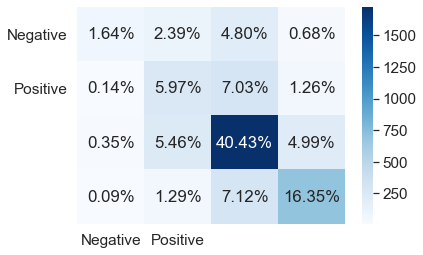

In [54]:
#A00
BNBModel = BernoulliNB()
fit_eval_model(BNBModel, tfidf_train, tfidf_test)

#### Model Performance Metrics

In [55]:
BNB_comet = BernoulliNB()
BNB_comet.fit(tfidf_train,y_train)
y_pred = BNB_comet.predict(tfidf_test)

#### Test Dataset Prediction Metrics

### Multinomial Naive Bayes

              precision    recall  f1-score   support

          -1       0.83      0.04      0.07       406
           0       0.67      0.09      0.17       615
           1       0.60      0.95      0.73      2187
           2       0.78      0.51      0.61      1061

    accuracy                           0.63      4269
   macro avg       0.72      0.40      0.40      4269
weighted avg       0.68      0.63      0.56      4269

F1_score: 0.5593993209459961


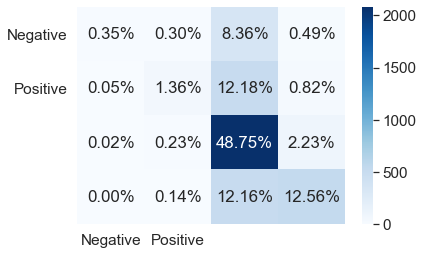

In [56]:
#A00

mb = MultinomialNB()
fit_eval_model(mb, tfidf_train, tfidf_test)

### Logistic Regression

C:\Users\USER\SeraApps\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

          -1       0.66      0.35      0.46       406
           0       0.49      0.42      0.45       615
           1       0.72      0.80      0.76      2187
           2       0.69      0.70      0.70      1061

    accuracy                           0.68      4269
   macro avg       0.64      0.57      0.59      4269
weighted avg       0.67      0.68      0.67      4269

F1_score: 0.6685904837252036


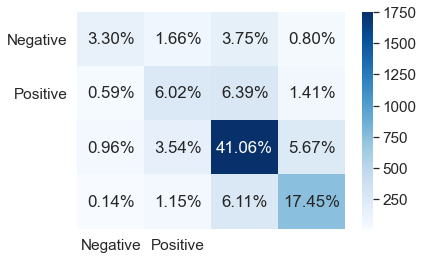

In [57]:
#A00
lr = LogisticRegression()
fit_eval_model(lr, cv_train, cv_test)

In [58]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(cv_train, y_train)

C:\Users\USER\SeraApps\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\SeraApps\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [59]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 1}


In [60]:
y_pred = grid.predict(cv_test)
f1 = f1_score(y_test, y_pred, average = 'weighted')

In [61]:
print(f1)

0.6685904837252036


### SVC

              precision    recall  f1-score   support

          -1       0.86      0.20      0.33       406
           0       0.63      0.26      0.37       615
           1       0.65      0.92      0.76      2187
           2       0.78      0.63      0.70      1061

    accuracy                           0.68      4269
   macro avg       0.73      0.50      0.54      4269
weighted avg       0.70      0.68      0.65      4269

F1_score: 0.6483354269565755


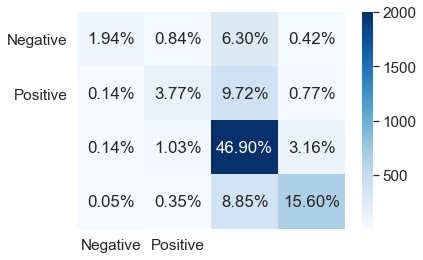

In [62]:
#A00
svc = SVC(kernel='rbf')
fit_eval_model(svc, tfidf_train, tfidf_test)

### Random Forest

              precision    recall  f1-score   support

          -1       0.72      0.25      0.37       406
           0       0.51      0.31      0.39       615
           1       0.66      0.84      0.74      2187
           2       0.70      0.61      0.65      1061

    accuracy                           0.65      4269
   macro avg       0.64      0.51      0.54      4269
weighted avg       0.65      0.65      0.63      4269

F1_score: 0.6315804409140583


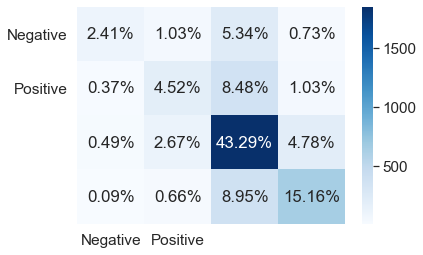

In [63]:
#A00
forest = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=200, bootstrap=False, random_state=42)
fit_eval_model(forest, tfidf_train, tfidf_test)

### Model Performance Comparison

### Hyperparameter Tuning (GridSearchCV)

#### Model Development on Comet

In [65]:
BNB_comet = BernoulliNB()
BNB_comet.fit(tfidf_train,y_train)
y_pred = BNB_comet.predict(tfidf_test)

In [66]:
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted', zero_division = 1)
recall = recall_score(y_test, y_pred, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[  70,  102,  205,   29],
       [   6,  255,  300,   54],
       [  15,  233, 1726,  213],
       [   4,   55,  304,  698]], dtype=int64)

In [67]:
params = {"test_size": 0.3,
          "model_type": "Bernoulli-Naive_Bayes",
          "vectorizer": "tfidf vectorizer",
          "param_grid": "None" ,
          "stratify": True
          }
metrics = {"f1 score": f1,
           "recall matrix": recall,
           "precision matrix": precision,
           'confusion matrix': confusion
           }
experiment_name = 'Bernoulli Naive Bayes Feature Engineering'

In [68]:
experiment.set_name(experiment_name)
experiment.log_parameters(params)
experiment.log_metrics(metrics)

COMET WARNING: Cannot safely convert array([[  70,  102,  205,   29],
       [   6,  255,  300,   54],
       [  15,  233, 1726,  213],
       [   4,   55,  304,  698]], dtype=int64) object to a scalar value, using its string representation for logging.


In [69]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/jessica-njuguna/tweet-sentiment-analysis/d4fbdd4b7d8847839e5d3c2bb761b6b7
COMET INFO:   Metrics:
COMET INFO:     confusion matrix : [[  70  102  205   29]
 [   6  255  300   54]
 [  15  233 1726  213]
 [   4   55  304  698]]
COMET INFO:     f1 score         : 0.6282353735815577
COMET INFO:     precision matrix : 0.650363951165302
COMET INFO:     recall matrix    : 0.6439447177324901
COMET INFO:   Others:
COMET INFO:     Name : Bernoulli Naive Bayes Feature Engineering
COMET INFO:   Parameters:
COMET INFO:     C                            : 1000.0
COMET INFO:     algorithm                    : auto
COMET INFO:     alpha                        : 1.0
COMET INFO:     analyzer                     : word
COMET INFO:     binarize                     : 0.

<a id="five"></a>
## 5. Model Explanation

<a id="six"></a>
## 6. Conclusion

<a id="seven"></a>
## 7. Appendix

### Kaggle Submission

#### Functions Declaration

In [70]:
#feed in preprocessing
#A00
def clean_vector(df):
    
    def test_preprocess(tweet):

        #remove urls
        tweet = re.sub(
                r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+',
                'url-web', tweet)
        #remove digits and words with digits
        tweet = re.sub('\w*\d\w*','', tweet)

        #make text lowercase
        tweet = tweet.lower() # lower case
        
    
        #expand contractions
        tweet = contractions.fix(tweet)

        
        #remove emojis
        tweet = emoji.replace_emoji(tweet, replace = '')
        
        #remove short words
        tweet = ' '.join([w for w in tweet.split() if len(w)>3])
        
        #remove punctuation
        tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet) # strip punctuation

        #lemmatize the text
        token_words = TreebankWordTokenizer().tokenize(tweet)
        lemmatizer = WordNetLemmatizer()
        lem_sentence=[]
        for word in token_words:
            #just lemmmatize
            lem_word = lemmatizer.lemmatize(word)
            lem_sentence.append(lem_word)
            lem_sentence.append(" ")
        tweet = "".join(lem_sentence)
    
        return tweet
    df['message'] = df['message'].apply(lambda x: test_preprocess(x))
    test_X = cv.transform(df['message'])
    return test_X

#### Submission Metrics

In [71]:
#A00

def submission(model, df):
    X = clean_vector(df)
    pred = model.predict(X)
    sub_id = df['tweetid'].to_list()
    sub_pred = pred.tolist()
    list_of_tuples = list(zip(sub_id, sub_pred))
    submission_df = pd.DataFrame(list_of_tuples,
                  columns = ['tweetid', 'sentiment'])
    submission_df.set_index('tweetid', inplace=True)
    return submission_df

In [72]:
#A00
submit_df = submission(lr, test_df)

In [73]:
submit_df['sentiment'].value_counts()

 1    6369
 2    2431
 0    1230
-1     516
Name: sentiment, dtype: int64

In [74]:
#A00
submit_df.to_csv('060422_Resample_Balanced_DF_CountVec_LogReg_Submission.csv')

submission_df.to_csv('280322_Cleaned_Vectorizer_Submission.csv') #score of 0.700

submission_df.to_csv('290322_Lemmatized_stemmd_Vectorizer_Submission.csv') #score of 0.68

submission_df.to_csv('050422_Streamlined_Vectorizer_Submission.csv') #score of 0.65